In [11]:
import numpy as np

from mazelab import ObjectDirectory

from mazelab.generators import BaseGenerator
from mazelab.generators import random_shape_maze

from mazelab import DeepMindColor as color


class Generator(BaseGenerator):
    def make_objects(self):
        obj_dir = ObjectDirectory(['value', 'color'])
        obj_dir.add_object('obstacle', 1, color.obstacle, True)
        obj_dir.add_object('free', 0, color.free, False)
        
        return obj_dir
    
    def __call__(self):
        x = random_shape_maze(width=50, height=50, max_shapes=50, max_size=8, allow_overlap=False, shape=None)
        out = x.tolist()
        
        for h, w in np.dstack(np.where(x == 1))[0]:
            out[h][w] = self.obstacle
        for h, w in np.dstack(np.where(x == 0))[0]:
            out[h][w] = self.free
        
        return out

In [12]:
from mazelab import Maze
from mazelab import Motion


generator = Generator()
maze = Maze(generator)
maze.to_value()

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [13]:
from mazelab import Motion

motion = Motion()
motion.add('north', [-1, 0])
motion.add('south', [1, 0])
motion.add('west', [0, -1])
motion.add('east', [0, 1])
motion

Motion: 
	north: [-1, 0]
	south: [1, 0]
	west: [0, -1]
	east: [0, 1]

In [18]:
from mazelab import Object
from mazelab import BaseNavigationEnv


class Env(BaseNavigationEnv):
    def step(self, action):
        action_name, delta = self.motion[action]
        
        current_position = self.state.positions[0]  # single agent
        new_position = [current_position[0] + delta[0], current_position[1] + delta[1]]
        
        valid = self.is_valid(new_position)
        if valid:
            self.state.positions[0] = new_position  # single agent
            
        if self.is_goal(new_position):
            reward = +1
            done = True
        elif not valid:
            reward = -1
            done = False
        else:
            reward = -0.01
            done = False
            
        info = {}
            
        return self.get_observation(), reward, done, info
        
    def reset(self):
        self.state = self.make_state()
        self.goal = self.make_goal()
        
        return self.get_observation()
        
    def make_state(self):
        state = Object('state', 2, color.agent, True, [[48, 48]])
        
        return state
        
    def make_goal(self):
        goal = Object('goal', 3, color.goal, False, [[1, 1]])
        
        return goal
        
    def is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        
        size = maze.size
        within_edge = position[0] < size[0] and position[1] < size[1]
        
        passable = not maze.to_impassable()[position[0]][position[1]]
        
        return nonnegative and within_edge and passable
        
    def is_goal(self, position):
        out = False
        for goal_position in self.goal.positions:
            if position[0] == goal_position[0] and position[1] == goal_position[1]:
                out = True
        
        return out


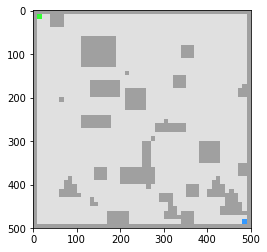

In [19]:
import matplotlib.pyplot as plt


env = Env(maze, motion)
img = env.render('rgb_array')
plt.imshow(img)

In [20]:
from gym.wrappers import Monitor
from mazelab.solvers import dijkstra_solver


actions = dijkstra_solver(np.array(env.maze.to_impassable()), env.motion, env.state.positions[0], env.goal.positions[0])
env = Monitor(env, directory='./', force=True)
env.reset()
for action in actions:
    env.step(action)
env.close()

WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
